In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
from virtualscada.vs import removeRows
from virtualscada.vs import fillValuesMLPFForward
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LinearRegression

%matplotlib inline

# Data Processing

First we add some data to our project. In order to use MLPowerflow, we need our phase angle to be in radians and our data to only be missing information across some number of rows. In this sample we get rid of 30% of rows, removing a column in a given row with probability 50%. 

In [2]:
p = pd.read_csv('C:/Users/Serhan/PycharmProjects/virtual-scada/Data/output_p.csv', header = None)
q = pd.read_csv('C:/Users/Serhan/PycharmProjects/virtual-scada/Data/output_q.csv', header = None)
v = pd.read_csv('C:/Users/Serhan/PycharmProjects/virtual-scada/Data/output_v.csv', header = None)
a = pd.read_csv('C:/Users/Serhan/PycharmProjects/virtual-scada/Data/output_a.csv', header = None)

In [3]:
a = pd.DataFrame(np.radians(a.values))

In [4]:
pRemoved = removeRows(p, .3, colPercentage = .5)
qRemoved = removeRows(q, .3, colPercentage = .5)

..\virtualscada\vs.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataRemoved[i][j] = None


# Virtual SCADA

Then we fill in our missing values. Our code takes in the fixed real power, reactive power, voltage, and phase angle and fills in the missing values using an MLPowerflow model that it trains from that data. max_iter, C_set, eps_set are all parameters that are passed to the MLPowerflow model during its training. There's an accuracy-speed trade off here, a smaller list of values will give you a weaker model, but will take significantly less time to train.  

In [5]:
pFilled, qFilled = fillValuesMLPFForward(pRemoved, qRemoved, v, a, max_iter = 1e4, C_set = [1,5,10], eps_set=[1e-5, 1e-3, 0.1, .3])

6.655213753996054 89.54031077294607


# Results

Now we look at the results of our filling. The following code manually computes the RMSE of our fill by comparing it with the values we removed at the first step. 

In [6]:
numRows, numCols = p.shape
predictions = []
actuals = []
for i in range(numCols):
    for j in range(numRows):
        if np.isnan(pRemoved[i][j]):
            predictions.append(pFilled[i][j])
            actuals.append(p[i][j])
                
print(np.sqrt(np.nanmean((np.array(predictions)-np.array(actuals))**2)))

142.23437502093552


Here is a plot of the results. The first plot is the actual power, the second is the power after being filled, and the third plot is the plot of the power with the missing values

Text(0, 0.5, 'Voltage Magnitude')

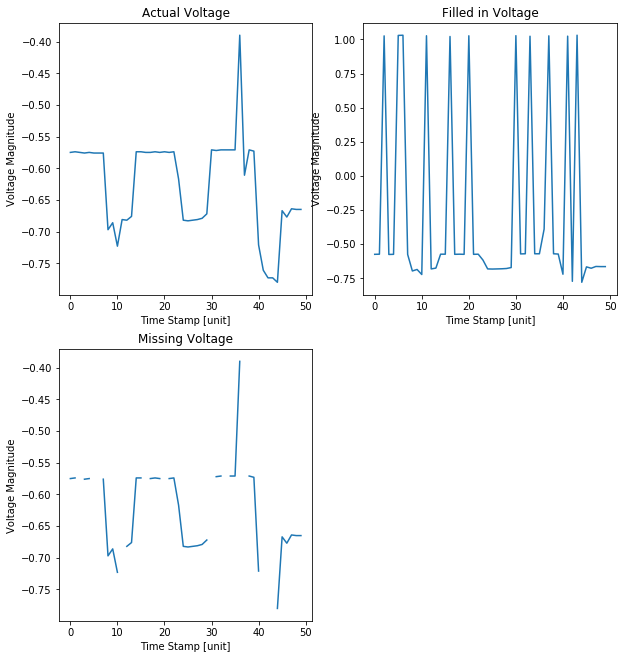

In [7]:
sampleBus = np.random.randint(0,29)

plt.figure(figsize=(10, 11))
plt.subplot(221)
plt.plot(p[sampleBus][0:50])
plt.title('Actual Voltage')
plt.xlabel('Time Stamp [unit]')
plt.ylabel('Voltage Magnitude')
plt.subplot(222)
plt.plot(pFilled[sampleBus][0:50])
plt.title('Filled in Voltage')
plt.xlabel('Time Stamp [unit]')
plt.ylabel('Voltage Magnitude')
plt.subplot(223)
plt.plot(pRemoved[sampleBus][0:50])
plt.title('Missing Voltage')
plt.xlabel('Time Stamp [unit]')
plt.ylabel('Voltage Magnitude')